In [497]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly pandas matplotlib tensorflow-datasets
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
2.21.0-dev20250728


In [498]:
# get data files
import os

training_file_path = "train-data.tsv"
testing_file_path = "valid-data.tsv"

if not os.path.exists(training_file_path):
    !curl -L -O https://cdn.freecodecamp.org/project-data/sms/train-data.tsv

if not os.path.exists(testing_file_path):
    !curl -L -O https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv


In [499]:
column_names = ["type", "message"]
training_df = pd.read_csv(filepath_or_buffer=training_file_path, sep="\t", names=column_names)

training_df.head()

,type,message
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [500]:
testing_df = pd.read_csv(filepath_or_buffer=testing_file_path, sep="\t", names=column_names)

testing_df.head()

,type,message
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


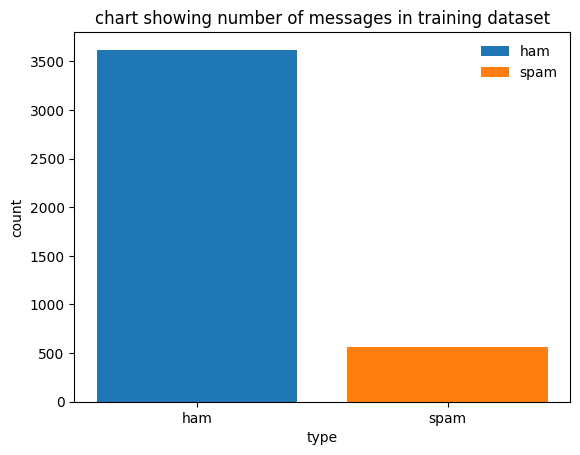

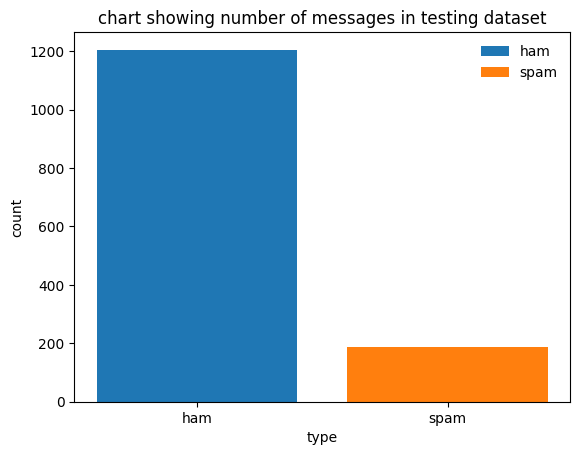

In [501]:
# visualize data
training_df_ham_count = training_df["type"].where(training_df["type"]=="ham").count()
training_df_spam_count = training_df["type"].where(training_df["type"]=="spam").count()
training_df_min_message_length = training_df["message"].min()
training_df_max_message_length = training_df["message"].max()
training_df_average_message_length = training_df["message"].map(lambda x: len(x)).mean()

testing_df_ham_count = testing_df["type"].where(testing_df["type"]=="ham").count()
testing_df_spam_count = testing_df["type"].where(testing_df["type"]=="spam").count()
testing_df_min_message_length = testing_df["message"].min()
testing_df_max_message_length = testing_df["message"].max()
testing_df_average_message_length = testing_df["message"].map(lambda x: len(x)).mean()

# chart #1
plt.title(label="chart showing number of messages in training dataset", loc="center")
plt.bar(x="ham", height=training_df_ham_count).set_label("ham")
plt.bar(x="spam", height=training_df_spam_count).set_label("spam")
plt.xlabel(xlabel="type")
plt.ylabel(ylabel="count")
plt.legend().set_frame_on(False)
plt.show()

# chart #2
plt.title(label="chart showing number of messages in testing dataset", loc="center")
plt.bar(x="ham", height=testing_df_ham_count).set_label("ham")
plt.bar(x="spam", height=testing_df_spam_count).set_label("spam")
plt.xlabel(xlabel="type")
plt.ylabel(ylabel="count")
plt.legend().set_frame_on(False)
plt.show()

In [502]:
# prepare dataset
training_df_copy = training_df.copy()
training_df_copy["type"] = training_df_copy["type"].map({"ham": 0, "spam": 1})

messages = training_df["message"].values
labels = training_df["label"].values

training_dataset = tf.data.Dataset.from_tensor_slices((messages, labels))
training_dataset = training_dataset.batch(64).prefetch(tf.data.AUTOTUNE)


KeyError: 'label'

In [ ]:
# NLP layer
language_processing = keras.layers.TextVectorization(    
    max_tokens=None,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=None,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
    encoding='utf-8',
)

language_processing.adapt(training_df["message"].values)

In [ ]:
# model
model = tf.keras.Sequential([
    keras.Input(shape=(1,), dtype=tf.string),
    language_processing,
    keras.layers.Embedding(input_dim=10001, output_dim=16),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer='adam',
    metrics=['accuracy']
)

model.fit(training_dataset, epochs=5)

In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text) -> list:
  model_prediction = model.predict(tf.constant([pred_text]))[0][0]
  threshold = 0.5
  prediction = [float(model_prediction), "spam" if model_prediction >= threshold else "ham"]
  return (prediction)

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions() -> None:
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()